<a href="https://colab.research.google.com/github/cfont03/Anomaly-breast-cancer-detection/blob/main/train/0.Data_Cleansing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Data upload

In [ ]:
# Mount google drive
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Access and unzip images
!unzip -q "/content/gdrive/My Drive/01_Database/archive.zip"
print("DONE!")

replace __MACOSX/._archive? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
DONE!


In [ ]:
from pathlib import Path
# Images directory
path = Path("/content/archive")

In [ ]:
# Importation of libraries, which will be needed during the data cleansing
from tensorflow import keras 
print("Keras version   : ", keras.__version__)

%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D)
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Model

%pylab inline
import cv2
import glob
import os
import matplotlib.pylab as plt

#from PIL import Image
import PIL.Image
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image
from keras.preprocessing import image as kp_image
#from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
#import tensorflow_addons as tfa

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns

Keras version   :  2.8.0
Populating the interactive namespace from numpy and matplotlib


#1. Exploratory analysis of data

In [ ]:
# Number of files in the folder

files = folders = 0

for _, dirnames, filenames in os.walk(path):
    files += len(filenames)
    folders += len(dirnames)

print ("{:} total number of files".format(files))

776 total number of files


In [ ]:
# Label exploration in .txt file
df_info = pd.read_csv("/content/archive/Info.txt", sep = " ", header = 'infer')

# Attribute info
print("Number of attributes: " , df_info.columns.values)

# Number of files
print("Number of files: ", df_info.shape[0])

# check df
print(df_info.head())

Number of attributes:  ['REFNUM' 'BG' 'CLASS' 'SEVERITY' 'X' 'Y' 'RADIUS' 'Unnamed: 7']
Number of files:  330
   REFNUM BG CLASS SEVERITY      X      Y  RADIUS  Unnamed: 7
0  mdb001  G  CIRC        B  535.0  425.0   197.0         NaN
1  mdb002  G  CIRC        B  522.0  280.0    69.0         NaN
2  mdb003  D  NORM      NaN    NaN    NaN     NaN         NaN
3  mdb004  D  NORM      NaN    NaN    NaN     NaN         NaN
4  mdb005  F  CIRC        B  477.0  133.0    30.0         NaN


In [ ]:
# Check for NaN in each column
df_info.isnull().sum(axis = 0)

REFNUM          0
BG              0
CLASS           0
SEVERITY      207
X             211
Y             211
RADIUS        211
Unnamed: 7    330
dtype: int64

In [ ]:
# NaN in last column = number of rows ====> drop last column
df_info = df_info.iloc[:, :-1]

In [ ]:
# Check number of cases per class of abnormality
df_info.groupby(['CLASS']).size()

CLASS
ARCH     19
ASYM     15
CALC     30
CIRC     25
MISC     15
NORM    207
SPIC     19
dtype: int64

In [ ]:
# we are only interested in the images, which present an abnormality. 
  # Drop NORM Class, equivalent to NaN values in Severity, x, y and Radius attributes
df_info_ = df_info.dropna()

# check it was correctly dropped
print(df_info_.groupby(['CLASS']).size())

CLASS
ARCH    19
ASYM    15
CALC    27
CIRC    24
MISC    15
SPIC    19
dtype: int64


In [ ]:
# Only keep coordinates, radius and class
df_info_ = df_info_.drop(df_info_.columns[[1,3]], axis = 1)

print(df_info_)

# check for number of files
print('\n\nNumber of images in dataset: ' , len(df_info_))

     REFNUM CLASS      X      Y  RADIUS
0    mdb001  CIRC  535.0  425.0   197.0
1    mdb002  CIRC  522.0  280.0    69.0
4    mdb005  CIRC  477.0  133.0    30.0
5    mdb005  CIRC  500.0  168.0    26.0
10   mdb010  CIRC  525.0  425.0    33.0
..      ...   ...    ...    ...     ...
281  mdb274  MISC  127.0  505.0   123.0
297  mdb290  CIRC  337.0  353.0    45.0
319  mdb312  MISC  240.0  263.0    20.0
321  mdb314  MISC  518.0  191.0    39.0
322  mdb315  CIRC  516.0  447.0    93.0

[119 rows x 5 columns]


Number of images in dataset:  119


In [ ]:
# Check again for NaN values
print(df_info_.isnull().sum(axis = 0))

# convert radius and coordinates into numeric values
df_info_.loc[:, 'RADIUS'] = pd.to_numeric(df_info_.RADIUS, downcast='integer')
df_info_.loc[:, 'X'] = pd.to_numeric(df_info_.X, downcast='integer')
df_info_.loc[:, 'Y'] = pd.to_numeric(df_info_.Y, downcast='integer')

##### CHECKPOINT
# save file into .csv
df_info_.to_csv("/content/archive/images_info_0.csv", sep = ",")

REFNUM    0
CLASS     0
X         0
Y         0
RADIUS    0
dtype: int64


In [ ]:
# Map images names with .txt file, which contains the labels
data = []
x_coord = []
y_coord = []
size = []
names = []
radius = []
image_path = []
cat = []

with open('/content/archive/images_info_0.csv') as file:
  next(file) # skip header
  for l in file:
    i = l.split(",")[1]
    images_path = '/content/archive/all-mias/{:}.pgm'.format(i)
    img = PIL.Image.open(images_path)
    data_arr = np.array(img.getdata())
    width, height = np.array(img.size)
    data.append(data_arr)
    size.append((width, height))
    names.append(np.array(i))
    cat.append(np.array(l.split(",")[2]))
    x_coord.append(np.array(l.split(",")[3]))
    y_coord.append(np.array(l.split(",")[4]))
    radius.append(np.array((l.split(",")[5]).rstrip()))
    image_path.append(images_path)


In [ ]:
# merge data into a df
arr = np.array([names, data, size, cat, x_coord, y_coord, radius, image_path], dtype = object).T.tolist()
df = pd.DataFrame(data = arr, columns = ['name', 'features', 'size', 'cat', 'x_coord', 'y_coord', 'radius', 'image path'])

# check df
df.head()

,name,features,size,cat,x_coord,y_coord,radius,image path
0,mdb001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,535,425,197,/content/archive/all-mias/mdb001.pgm
1,mdb002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,522,280,69,/content/archive/all-mias/mdb002.pgm
2,mdb005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,477,133,30,/content/archive/all-mias/mdb005.pgm
3,mdb005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,500,168,26,/content/archive/all-mias/mdb005.pgm
4,mdb010,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,525,425,33,/content/archive/all-mias/mdb010.pgm


In [ ]:
# substract y-coord from 1024 value to mirror
df['y_coord'] = 1024 - df['y_coord'].astype(str).astype(int)

In [ ]:
df.head()

,name,features,size,cat,x_coord,y_coord,radius,image path
0,mdb001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,535,599,197,/content/archive/all-mias/mdb001.pgm
1,mdb002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,522,744,69,/content/archive/all-mias/mdb002.pgm
2,mdb005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,477,891,30,/content/archive/all-mias/mdb005.pgm
3,mdb005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,500,856,26,/content/archive/all-mias/mdb005.pgm
4,mdb010,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,525,599,33,/content/archive/all-mias/mdb010.pgm


In [ ]:
# check if all images have the same size
df.groupby(['size']).count()

,name,features,cat,x_coord,y_coord,radius,image path
size,,,,,,,
"(1024, 1024)",119,119,119,119,119,119,119


In [ ]:
# check for duplicated images
df[df.name.duplicated()].name

3      mdb005
46     mdb132
51     mdb144
90     mdb223
92     mdb226
93     mdb226
99     mdb239
105    mdb249
Name: name, dtype: object

In [ ]:
# check in which rows are these located and if the coord and radius are different
for i in df[df.name.duplicated()].name:
  print(df.loc[df['name'] == i].iloc[:,-4:])

  x_coord  y_coord radius                            image path
2     477      891     30  /content/archive/all-mias/mdb005.pgm
3     500      856     26  /content/archive/all-mias/mdb005.pgm
   x_coord  y_coord radius                            image path
45     252      236     52  /content/archive/all-mias/mdb132.pgm
46     335      258     18  /content/archive/all-mias/mdb132.pgm
   x_coord  y_coord radius                            image path
50     233       30     29  /content/archive/all-mias/mdb144.pgm
51     313      484     27  /content/archive/all-mias/mdb144.pgm
   x_coord  y_coord radius                            image path
89     523      542     29  /content/archive/all-mias/mdb223.pgm
90     591      495      6  /content/archive/all-mias/mdb223.pgm
   x_coord  y_coord radius                            image path
91     287      414      7  /content/archive/all-mias/mdb226.pgm
92     329      474     25  /content/archive/all-mias/mdb226.pgm
93     531      303      8  

Radius and coord differ, meaning more than one abnormality is present in the same image.

In [ ]:
# generate bounding boxes
df['xmin'] = df['x_coord'].apply(int) - df['radius'].apply(int)
df['xmax'] = df['x_coord'].apply(int) + df['radius'].apply(int)
df['ymin'] = df['y_coord'].apply(int) - df['radius'].apply(int)
df['ymax'] = df['y_coord'].apply(int) + df['radius'].apply(int)

###### CHECKPOINT
# Save to .csv
df.to_csv("/content/archive/images_info_1.csv", sep = ",")

# 2. Image preprocessing

Image:  mdb001_hflip.jpeg


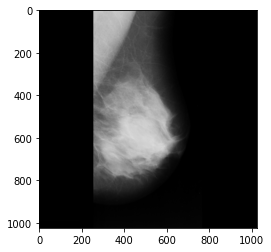

In [ ]:
# check one random image as example
path = Path('/content/archive/all-mias')
img_rand = random.choice([x for x in os.listdir(path) 
                        if os.path.isfile(os.path.join(path, x))])

print("Image: ", img_rand)
plt.imshow(cv2.imread('/content/archive/all-mias/{:}'.format(img_rand)))

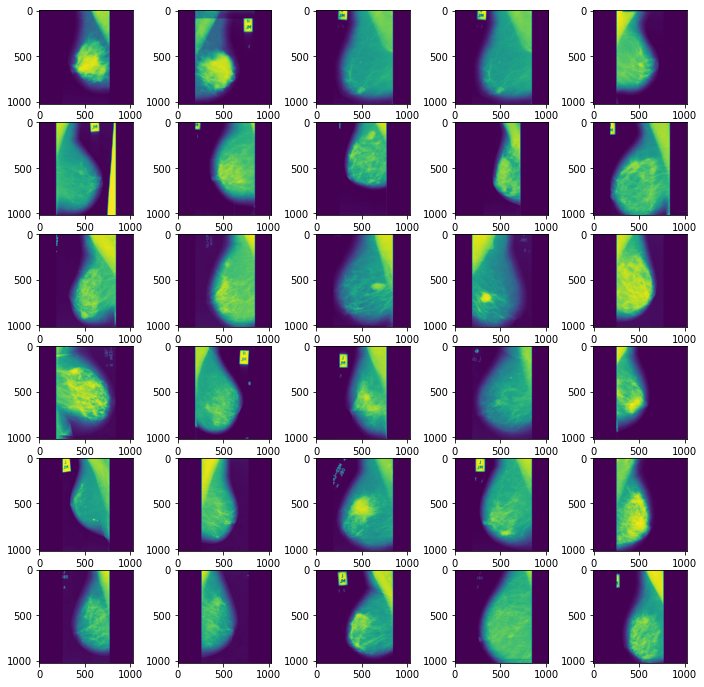

In [ ]:
# show sample of images
  # load images

def load_img(path_to_img):
  max_dim = 1024
  img = PIL.Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), PIL.Image.ANTIALIAS)
   
  img = kp_image.img_to_array(img)
  
  img = np.expand_dims(img, axis=0)
  return img



# show images
def imshow(img, title=None):
  out = np.squeeze(img, axis=0)

  out = out.astype('uint8') # normalize for visualization
  plt.imshow(out[:,:,0])
  if title is not None:
    plt.title(title)
  



# plot images
plt.figure(figsize=(12,12)) 

for i in range(0,30):
    plt.subplot(6,5,i+1)
    content = load_img(image_path[i]).astype('uint8')
    imshow(content)

plt.show()

## 2.1. Horizontal flip

In [ ]:
# function to generate a horizontal flip to the images
def horizontal_flip (info_file, display = False):

  ''' 
  
  Function to apply a horizontal flip to the images

  Params:
    0: reference number
    1: features
    2: size
    3: class
    4: x_coordinate of the abnormality
    5: y_coordiante of the abnormality
    6: radius in pixels
    7: path of the image
    8: xmin coordinate bounding box
    9: ymin coordinate bounding box
    10: xmax coordinate bounding box
    11: ymax coordinate bounding box
  
  '''

  x_y = []
  x_min_max = []
  y_min_max = []

  for name, path, size_x, size_y, xcoord, ycoord, xmin, ymin, xmax, ymax in zip(info_file.iloc[:, 0], info_file.iloc[:, 7], 
                                                                                info_file.iloc[:, 2], info_file.iloc[:, 2],
                                                                                info_file.iloc[:, 4], info_file.iloc[:, 5],
                                                                                info_file.iloc[:, 8], info_file.iloc[:, 9],
                                                                                info_file.iloc[:, 10], info_file.iloc[:, 11]):
  
    hflip_ = cv2.imread(str(path)) # read image
    hflip = cv2.flip(hflip_, 1) # horizontal flip
    new_path = Path("/content/archive/all-mias/{:}_hflip{:}".format(name, '.jpeg')) # generate new path
    status = cv2.imwrite(str(new_path), hflip) # save new img
    print("Image written to file-system " , new_path,  " :", status) # check if saved properly

    ### adapt bounding boxes points
    xcoord_ = int(1024) - int(xcoord) # needs to be 1024 dynamic
    xmin_ = int(1024) - int(xmin)
    xmax_ = int(1024) - int(xmax)
    x_y.append(np.array([[xcoord_, ycoord]]))
    x_min_max.append(np.array([[xmin_, xmax_]]))
    y_min_max.append(np.array([[ymin, ymax]]))
  
  return x_y, x_min_max, y_min_max

In [ ]:
# apply to our database
x_y_hf, x_min_max_hf, y_min_max_hf = horizontal_flip(df)

Image written to file-system  /content/archive/all-mias/mdb001_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb002_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb005_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb005_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb010_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb012_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb013_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb015_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb017_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb019_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb021_hflip.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb023_hflip.jpeg  : True
Image written to

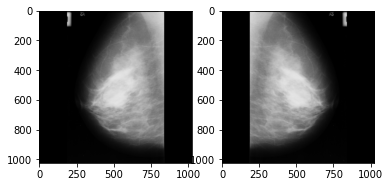

In [ ]:
# check image as example
img = cv2.imread('/content/archive/all-mias/mdb315.pgm')

hflip = cv2.imread('/content/archive/all-mias/mdb315_hflip.jpeg')
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(hflip)
plt.show()

## 2.2. Removing noise

In [ ]:
# function to remove noise 
def remove_noise (info_file):

  '''
  
  Function removes noise of images contained in a file
  
  Params:
    0: reference number ==> relevant
    1: features
    2: size
    3: class
    4: x_coordinate of the abnormality
    5: y_coordiante of the abnormality
    6: radius in pixels
    7: path of the image ==> relevant

  Gaussian noise is assumed
  
  '''

  for name, path in zip(info_file.iloc[:, 0], info_file.iloc[:, 7]):
    noise_ = cv2.imread(path) # read image
    noise = cv2.fastNlMeansDenoising(noise_,None,10,7,21) # remove noise
    new_path = '/content/archive/all-mias/{:}_noise.jpeg'.format(name) # generate new path
    status = cv2.imwrite(str(new_path), noise) # save new img
    print("Image written to file-system " , new_path,  " :", status) # check if saved properly

In [ ]:
# apply to our database
remove_noise(df)

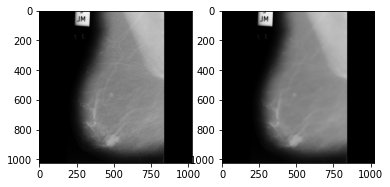

In [ ]:
# check image as example
img = cv2.imread('/content/archive/all-mias/mdb005.pgm')

noise = cv2.imread('/content/archive/all-mias/mdb005_noise.jpeg')
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(noise)
plt.show()

## 2.3. Rotation images

In [ ]:
# function to rotate images
def rotate_images (info_file, display = False):

  ''' 

  Function to rotate images for the files in the database 

  Params:
    0: reference number
    1: features
    2: size
    3: class
    4: x_coordinate of the abnormality
    5: y_coordiante of the abnormality
    6: radius in pixels
    7: path of the image
    8: xmin
    9: ymin
    10: xmax
    11: ymax
  
  '''

  x_y = []
  x_min_max = []
  y_min_max = []

  for name, path, xcoord, ycoord, xmin, ymin, xmax, ymax in zip(info_file.iloc[:, 0], info_file.iloc[:, 7], 
                                              info_file.iloc[:, 4], info_file.iloc[:, 5],
                                              info_file.iloc[:, 8], info_file.iloc[:, 9],
                                              info_file.iloc[:, 10], info_file.iloc[:, 11]):
    img = cv2.imread(path) # read image
    (h, w) = img.shape[:2] # dimensions image
    (cX, cY) = (w // 2, h // 2) # capture centre image
    rot = cv2.getRotationMatrix2D((cX, cY), 45, 1) # rotate image 45 degrees around the centre
    rotated = cv2.warpAffine(img, rot, (w, h))
    
    # rotate points accordingly
    xy = np.array([[int(xcoord), int(ycoord)]])
    ones = np.ones(shape=(len(xy), 1))
    xy_ones = np.hstack([xy, ones])
    xy_points = rot.dot(xy_ones.T).T
    x_y.append(xy_points)

    # xmin_xmax
    x = np.array([[int(xmin), int(xmax)]])
    ones = np.ones(shape=(len(x), 1))
    x_ones = np.hstack([x, ones])
    x_points = rot.dot(x_ones.T).T
    x_min_max.append(x_points)

    # ymin_ymax
    y = np.array([[int(ymin), int(ymax)]])
    ones = np.ones(shape=(len(y), 1))
    y_ones = np.hstack([y, ones])
    y_points = rot.dot(y_ones.T).T
    y_min_max.append(y_points)


    new_path = '/content/archive/all-mias/{:}_rotate.jpeg'.format(name) # generate new path
    status = cv2.imwrite(str(new_path), rotated) # save new img
    print("Image written to file-system " , new_path,  " :", status) # check if saved properly

  return x_y, x_min_max, y_min_max

In [ ]:
# rotate images
x_y, x_min_max, y_min_max = rotate_images(df)

Image written to file-system  /content/archive/all-mias/mdb001_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb002_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb005_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb005_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb010_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb012_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb013_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb015_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb017_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb019_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb021_rotate.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb023_rotate.jpeg  : True
Imag

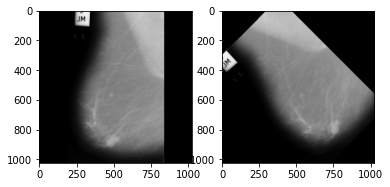

In [ ]:
# check image as example
img = cv2.imread('/content/archive/all-mias/mdb005.pgm')

rotate = cv2.imread('/content/archive/all-mias/mdb005_rotate.jpeg')
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(rotate)
plt.show()

## 2.4. Mask

In [ ]:
# function to generate a mask to the images
def generate_mask (info_file, display = False):

  ''' 

  Function to generate masks for the images in the database 

  Params:
    0: reference number
    1: features
    2: size
    3: class
    4: x_coordinate of the abnormality
    5: y_coordiante of the abnormality
    6: radius in pixels
    7: path of the image
  
  '''

  for name, size, x_coord, y_coord, radius in zip(info_file.iloc[:, 0], info_file.iloc[:, 2], 
                                                  info_file.iloc[:, 4], info_file.iloc[:, 5], info_file.iloc[:, 6]):
    mask = np.zeros(shape=size, dtype=np.uint8)
    cv2.circle(mask, center = (int(x_coord), int(y_coord)), radius = radius, thickness = -1, color = (255, 255, 255)) # highlight the abnormalities in white colour
    new_path = '/content/archive/all-mias/{:}_mask.pgm'.format(name) # generate new path
    status = cv2.imwrite(str(new_path), mask) # save mask
    print("Image written to file-system " , new_path,  " :", status) # check if saved properly

In [ ]:
# apply to df
generate_mask(df)

Image written to file-system  /content/archive/all-mias/mdb001_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb002_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb005_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb005_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb010_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb012_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb013_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb015_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb017_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb019_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb021_mask.pgm  : True
Image written to file-system  /content/archive/all-mias/mdb023_mask.pgm  : True
Image written to file-system  /content/a

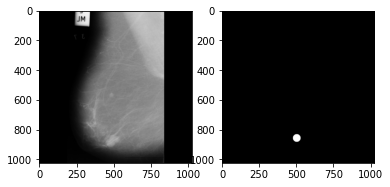

In [ ]:
# check image as example
img = cv2.imread('/content/archive/all-mias/mdb005.pgm')

mask = cv2.imread('/content/archive/all-mias/mdb005_mask.pgm')
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(mask)
plt.show()

## 2.8 Compile images in a df

In [ ]:
# Map images names with .csv file, which contains the labels
data = []
x_coord = []
y_coord = []
categ = []
xmin = []
ymin = []
xmax = []
ymax = []
size = []
names = []
radius = []
image_path = []
categories = ['_hflip','_noise', '_rotate']
masks = ['_mask']

with open('/content/archive/images_info_1.csv') as file:
  next(file) # skip header
  for l in file:
    z = 0
    for cat in categories:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.jpeg'.format(i, cat)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, cat)))
      categ.append(np.array(l.split(",")[5]))
      if cat == '_rotate':
        x_coord.append(x_y[z][0][0])
        y_coord.append(x_y[z][0][1])
        xmin.append(x_min_max[z][0][0])
        xmax.append(x_min_max[z][0][1])
        ymin.append(y_min_max[z][0][0])
        ymax.append(y_min_max[z][0][1])
      elif cat == '_hflip':
        x_coord.append(x_y_hf[z][0][0])
        y_coord.append(x_y_hf[z][0][1])
        xmin.append(x_min_max_hf[z][0][0])
        xmax.append(x_min_max_hf[z][0][1])
        ymin.append(y_min_max_hf[z][0][0])
        ymax.append(y_min_max_hf[z][0][1])  
      else:
        x_coord.append(np.array(l.split(",")[6]))
        y_coord.append(np.array(l.split(",")[7]))
        xmin.append(np.array(l.split(",")[10]))
        xmax.append(np.array(l.split(",")[11]))
        ymin.append(np.array(l.split(",")[12]))
        ymax.append(int(np.array(l.split(",")[13])))

      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)
      z += 1
    for m in masks:
      i = l.split(",")[1]
      path = '/content/archive/all-mias/{:}{:}.pgm'.format(i, m)
      img = PIL.Image.open(path)
      data_arr = np.array(img.getdata())
      width, height = np.array(img.size)
      data.append(data_arr)
      size.append((width, height))
      names.append(np.array('{:}{:}'.format(i, m)))
      categ.append(np.array(l.split(",")[5]))
      x_coord.append(np.array(l.split(",")[6]))
      y_coord.append(np.array(l.split(",")[7]))
      xmin.append(np.array(l.split(",")[10]))
      xmax.append(np.array(l.split(",")[11]))
      ymin.append(np.array(l.split(",")[12]))
      ymax.append(int(np.array(l.split(",")[13])))
      radius.append(np.array((l.split(",")[8]).rstrip()))
      image_path.append(path)  

In [ ]:
# merge data into a df
arr = np.array([names, data, size, categ, x_coord, y_coord, xmin, xmax, ymin, ymax, radius, image_path], dtype = object).T.tolist()
df_ = pd.DataFrame(data = arr, columns = ['name', 'features', 'size', 'cat', 'x_coord', 'y_coord', 'xmin', 'xmax', 
                                          'ymin', 'ymax', 'radius', 'image path'])

# check df
df_.tail()

,name,features,size,cat,x_coord,y_coord,xmin,xmax,ymin,ymax,radius,image path
471,mdb314_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",MISC,518,833,479,557,794,872.000000,39,/content/archive/all-mias/mdb314_mask.pgm
472,mdb315_hflip,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CIRC,489,599,686,622,732,796.000000,93,/content/archive/all-mias/mdb315_hflip.jpeg
473,mdb315_noise,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CIRC,516,577,423,609,484,670.000000,93,/content/archive/all-mias/mdb315_noise.jpeg
474,mdb315_rotate,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CIRC,755.244733,804.742207,712.818326,804.742207,797.67114,804.742207,93,/content/archive/all-mias/mdb315_rotate.jpeg
475,mdb315_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,516,577,423,609,484,670.000000,93,/content/archive/all-mias/mdb315_mask.pgm


In [ ]:
# load previous df
df = pd.read_csv('/content/archive/images_info_1.csv', sep = ',')

print(df.head())

# drop column 0
del df['Unnamed: 0']

# concatenate two df
df_pp = pd.concat([df, df_])

# check df
print(df_pp.head())

   Unnamed: 0    name               features          size   cat  x_coord  \
0           0  mdb001  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CIRC      535   
1           1  mdb002  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CIRC      522   
2           2  mdb005  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CIRC      477   
3           3  mdb005  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CIRC      500   
4           4  mdb010  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CIRC      525   

   y_coord  radius                            image path  xmin  xmax  ymin  \
0      599     197  /content/archive/all-mias/mdb001.pgm   338   732   402   
1      744      69  /content/archive/all-mias/mdb002.pgm   453   591   675   
2      891      30  /content/archive/all-mias/mdb005.pgm   447   507   861   
3      856      26  /content/archive/all-mias/mdb005.pgm   474   526   830   
4      599      33  /content/archive/all-mias/mdb010.pgm   492   558   566   

   ymax  
0   796  
1   813  
2   921  
3   882  
4   632  
     nam

In [ ]:
# check for NaN
df_pp.isnull().sum(axis = 0)

name          0
features      0
size          0
cat           0
x_coord       0
y_coord       0
radius        0
image path    0
xmin          0
xmax          0
ymin          0
ymax          0
dtype: int64

In [ ]:
# check example of mdb001
df_pp[df_pp['image path'].str.contains('mdb001')]

,name,features,size,cat,x_coord,y_coord,radius,image path,xmin,xmax,ymin,ymax
0,mdb001,[0 0 0 0 ... 0 0 0 0],"(1024, 1024)",CIRC,535,599,197,/content/archive/all-mias/mdb001.pgm,338,732,402,796.000000
0,mdb001_hflip,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CIRC,489,599,197,/content/archive/all-mias/mdb001_hflip.jpeg,686,622,732,796.000000
1,mdb001_noise,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CIRC,535,599,197,/content/archive/all-mias/mdb001_noise.jpeg,338,732,402,796.000000
2,mdb001_rotate,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","(1024, 1024)",CIRC,755.244733,804.742207,197,/content/archive/all-mias/mdb001_rotate.jpeg,712.818326,804.742207,797.67114,804.742207
3,mdb001_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1024, 1024)",CIRC,535,599,197,/content/archive/all-mias/mdb001_mask.pgm,338,732,402,796.000000


In [ ]:
df_pp['radius'].apply(int) + df_pp['x_coord'].apply(int) + df_pp['y_coord'].apply(int) + df_pp['xmin'].apply(int)
+ df_pp['xmax'].apply(int) + df_pp['ymin'].apply(int) + df_pp['ymax'].apply(int)

0      1930
1      2079
2      2289
3      2238
4      1756
       ... 
471    2223
472    2150
473    1763
474    2405
475    1763
Length: 595, dtype: int64

In [ ]:
### CHECKPOINT
# save df into .csv
df_pp.to_csv("/content/archive/images_preprocess.csv", sep = ";")